---
author: Nazmus Salehin, Martin Proks
title: 02 - Load and integrate SMART-seq2 sequencing of mouse blastocysts
date: 30-09-2024
model: v1.1
---

In [1]:
!which pip

~/projects/data/Brickman/conda/envs/scvi-1.1.5/bin/pip


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scvi
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import jax
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

In [4]:
import sys; sys.path.append("../scripts/")
from helpers import normalize_smartseq

In [5]:
GENE_LEN = '~/Brickman/shared/references/mus_musculus/ensembl/GRCm38_102/Mus_musculus_GRCm38_102_gene_length.txt'

In [6]:
import urllib.request, json

cc_url = "https://github.com/brickmanlab/project-template/raw/master/%7B%7B%20cookiecutter.project_name%20%7D%7D/data/external/mouse_cell_cycle_genes.json"
with urllib.request.urlopen(cc_url) as url:
    cc_dict = json.load(url)
    CC = sum(list(cc_dict.values()), [])

## 1. Analysis

In [7]:
adata = sc.read_h5ad("../data/external/niakan_et_al/mouse/mtx_conversions/combined_matrix.h5ad")
adata.obs['LIMS.ID'] = adata.obs['sample'].str.split('_', expand=True).iloc[:, 0]
adata.obs = adata.obs.merge(pd.read_csv("../data/processed/Samples_LIMSID.csv"), 
                            left_on='LIMS.ID', right_on='LIMS.ID', how='left').set_index(adata.obs_names)
adata.obs['batch'] = "NIAKAN_1"
adata.obs['experiment'] = "Simon et al, 2024"
adata.obs['technology'] = "SMART-seq2"

adata

AnnData object with n_obs × n_vars = 288 × 55487
    obs: 'sample', 'fastq_1', 'fastq_2', 'LIMS.ID', 'Sample.name', 'Vol.ul', 'Conc.pg/ul', 'Mass.ng', 'QC', 'Plate.no', 'Species', 'Sample.collection.date', 'Embryo', 'Treatment', 'Stage', 'cDNA.prep.date', 'Lot.no.cDNA.kit', 'ASF.submission.date', 'batch', 'experiment', 'technology'
    var: 'gene_symbol'

In [8]:
adata = adata[adata.obs.QC == "Pass"].copy()
adata = adata[~adata.obs.Treatment.isna()].copy()

In [9]:
adata.var['mt'] = adata.var.gene_symbol.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

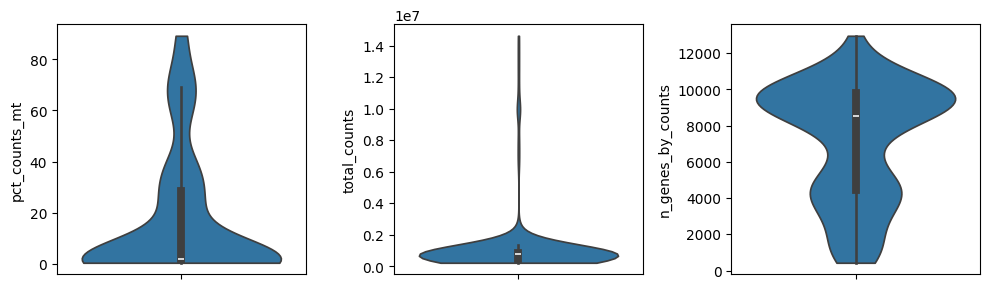

In [10]:
fig, ax = plt.subplots(1, 3, figsize=[10, 3])
sns.violinplot(y=adata.obs['pct_counts_mt'], orient='v', cut=0, ax=ax[0])
sns.violinplot(y=adata.obs['total_counts'], orient='v', cut=0, ax=ax[1])
sns.violinplot(y=adata.obs['n_genes_by_counts'], orient='v', cut=0, ax=ax[2])
fig.tight_layout()

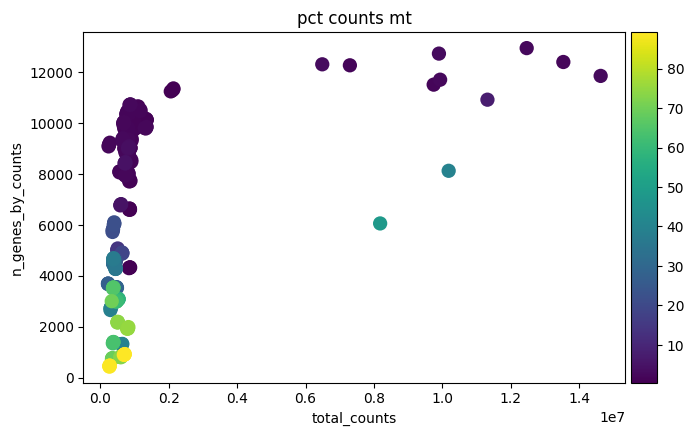

In [11]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [12]:
adata = adata[adata.obs.pct_counts_mt < 15].copy()

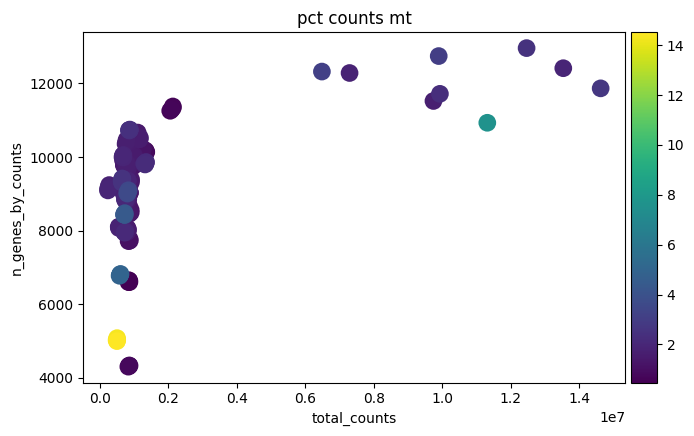

In [13]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [14]:
# sc.pp.filter_cells(adata, min_counts=2.5e5)
# sc.pp.filter_cells(adata, max_counts=1e7)
# sc.pp.filter_cells(adata, min_genes=2_000)

## 2. Prep for model

In [15]:
adata = normalize_smartseq(adata, GENE_LEN)

SMART-SEQ: Normalization
SMART-SEQ: Common genes 55364


In [16]:
adata.var['gene_id'] = adata.var_names
adata.var_names = adata.var.gene_symbol.str.lower().values
adata.var_names_make_unique()

In [17]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

In [18]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=3_000, batch_key="batch")

In [19]:
sc.tl.pca(adata)

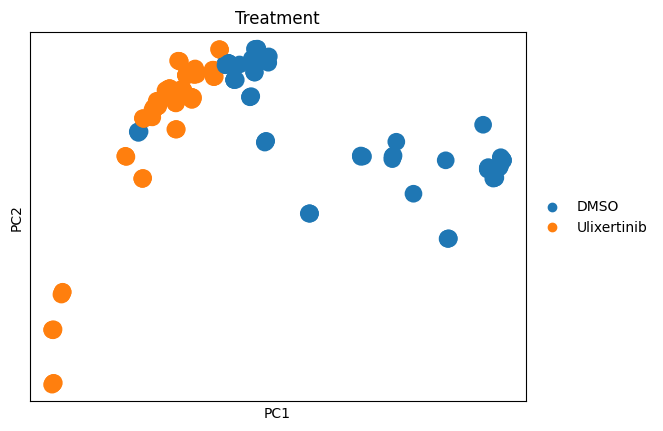

In [20]:
sc.pl.pca(adata, color='Treatment')

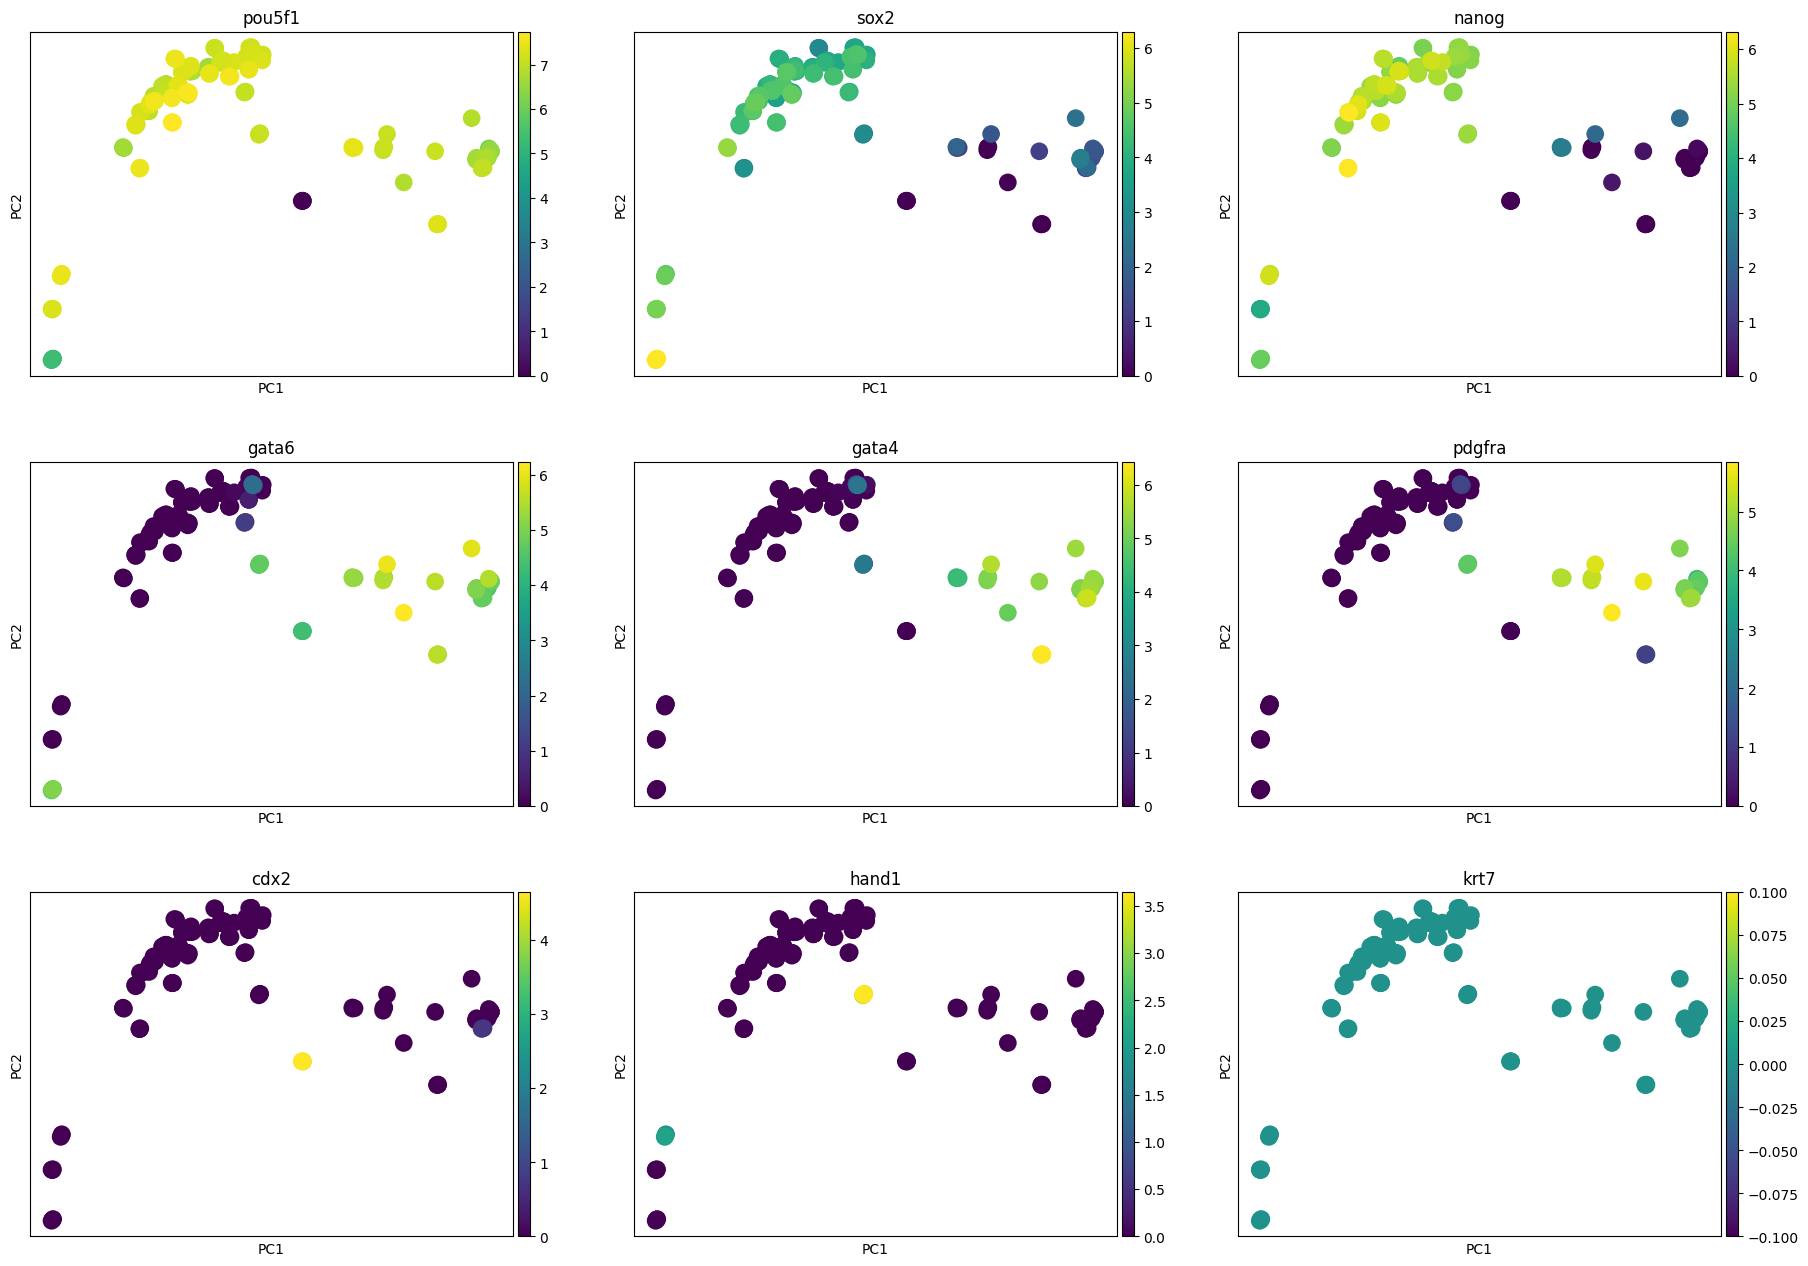

In [21]:
sc.pl.pca(adata, color = [
    'pou5f1', 'sox2', 'nanog',
    'gata6', 'gata4', 'pdgfra',
    'cdx2', 'hand1', 'krt7'
], ncols=3)

## 3. Load and retrain model

### 3.0. Training

In [ ]:
vae = scvi.model.SCVI.load('/home/fdb589/Brickman/projects/proks-salehin-et-al-v2/results/100_mouse_integration/scvi')
vae

In [35]:
vae.adata.obs['ct_custom'] = vae.adata.obs.ct.replace('E3.75-ICM', 'Unknown')

In [ ]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, labels_key="ct_custom", unlabeled_category="Unknown")
lvae.train(max_epochs=20, n_samples_per_label=15)

In [37]:
lvae.save("../results/07_mouse_scanvi_ns_15", overwrite=True, save_anndata=True)

In [38]:
lvae.adata.obs['predictions'] = lvae.predict()

In [ ]:
order = lvae.adata.obs.ct_custom.cat.categories.drop('Unknown')
sns.heatmap(sc.metrics.confusion_matrix("ct", "predictions", lvae.adata.obs).loc[order, order], linewidth=.5, vmin=0, vmax=1)

In [ ]:
pd.crosstab(lvae.adata.obs.ct_custom, lvae.adata.obs.predictions).loc[['Unknown']]

### 3.1. Predict

In [22]:
lvae = scvi.model.SCANVI.load('../results/07_mouse_scanvi_ns_15/')

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ../results/07_mouse_scanvi_ns_15/model.pt already downloaded                                         


/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary

In [23]:
scvi.model.SCANVI.prepare_query_anndata(adata, lvae)
lvae_q = scvi.model.SCANVI.load_query_data(adata, lvae)

INFO     Found 100.0% reference vars in query data.                                                                


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scvi/data/_manager.py:215: UserWarning: Missing labels key ct_custom. Filling in with unlabeled category Unknown.
  field_registry[_constants._STATE_REGISTRY_KEY] = field.transfer_field(


In [24]:
lvae_q.train(max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10, early_stopping=True)

INFO     Training for 100 epochs.                                                                                  


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is 

Epoch 75/100:  75%|███████▌  | 75/100 [00:10<00:03,  7.19it/s, v_num=1, train_loss_step=4.95e+3, train_loss_epoch=4.83e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 4459.801. Signaling Trainer to stop.


In [25]:
adata.obsm["X_scANVI"] = lvae_q.get_latent_representation()
adata.obs['prediction'] = lvae_q.predict()
adata.obs['entropy'] = 1 - lvae_q.predict(soft=True).max(axis=1)

lvae_q.adata.obsm["X_scANVI"] = lvae_q.get_latent_representation()
lvae_q.adata.obs['prediction'] = lvae_q.predict()
lvae_q.adata.obs['entropy'] = 1 - lvae_q.predict(soft=True).max(axis=1)

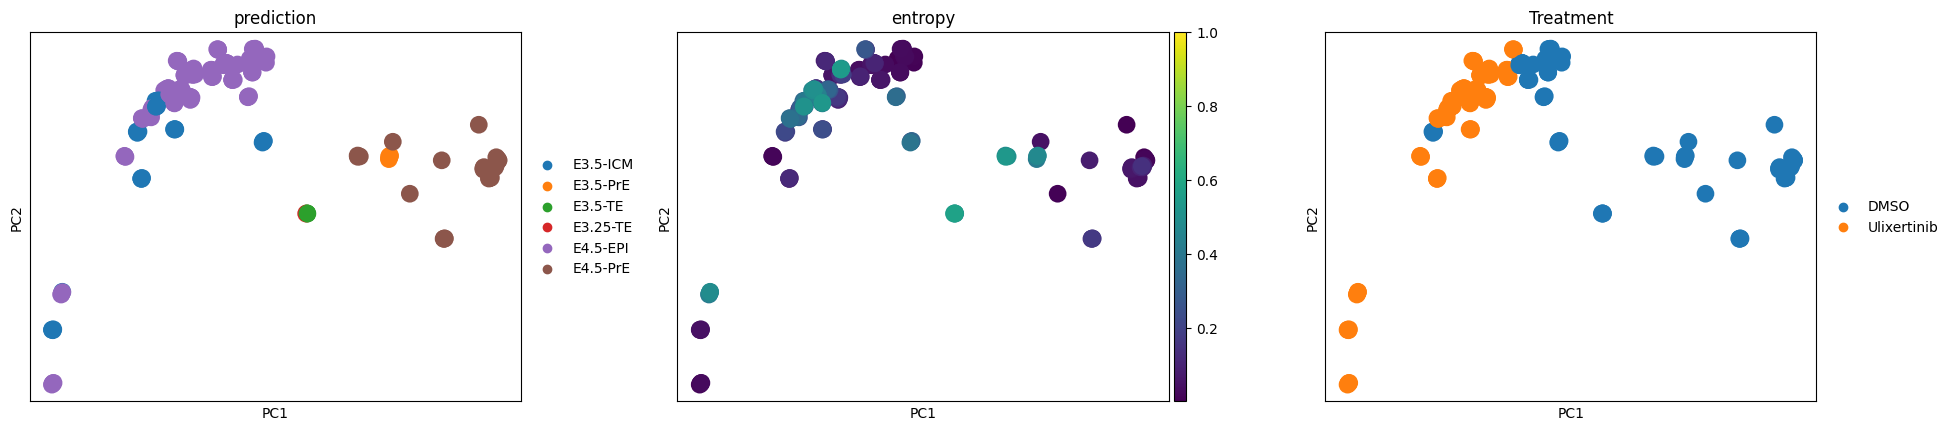

In [26]:
sc.pl.pca(adata, color = ['prediction', 'entropy', 'Treatment'], wspace=0.2, vmax=1)

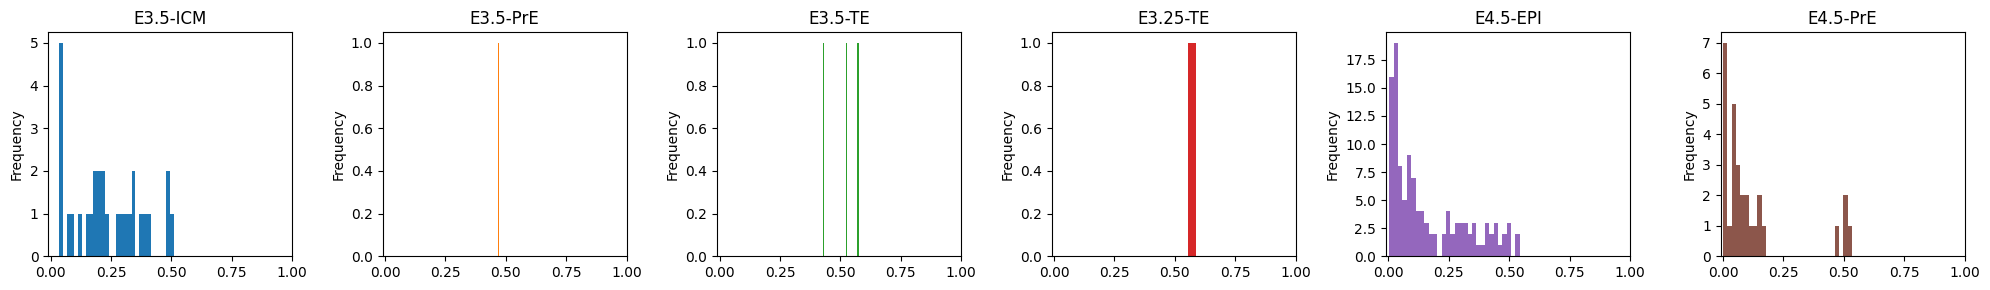

In [27]:
fig, ax = plt.subplots(1, adata.obs.prediction.unique().size, sharex=True, figsize=[20, 3])
for idx, p in enumerate(adata.obs.prediction.cat.categories):
    adata.obs.query('prediction == @p')['entropy']\
        .plot.hist(bins=30, ax=ax[idx], title=p, xlabel='', xlim=(-0.01,1),
                   color=adata.uns['prediction_colors'][idx])
fig.tight_layout()

In [28]:
adata.write('../results/07_niakan_mouse_treatment_query.h5ad')
lvae_q.save('../results/07_query', overwrite=True, save_anndata=True)

## 4. Figures and stuff

In [68]:
lvae = scvi.model.SCANVI.load('../results/07_mouse_scanvi_ns_15/')
lvae.adata.obs['prediction'] = lvae.predict()

lvae_q = scvi.model.SCANVI.load('../results/07_query/')
lvae_q.adata.obs['stage'] = lvae_q.adata.obs.prediction.str.split('-', expand=True)[1].values

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ../results/07_mouse_scanvi_ns_15/model.pt already downloaded                                         


/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary

INFO     File ../results/07_query/model.pt already downloaded                                                      


/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary

### 4.1. Remove TE cells

In [69]:
adata_sub = lvae_q.adata[~lvae_q.adata.obs.prediction.str.endswith('TE')].copy()

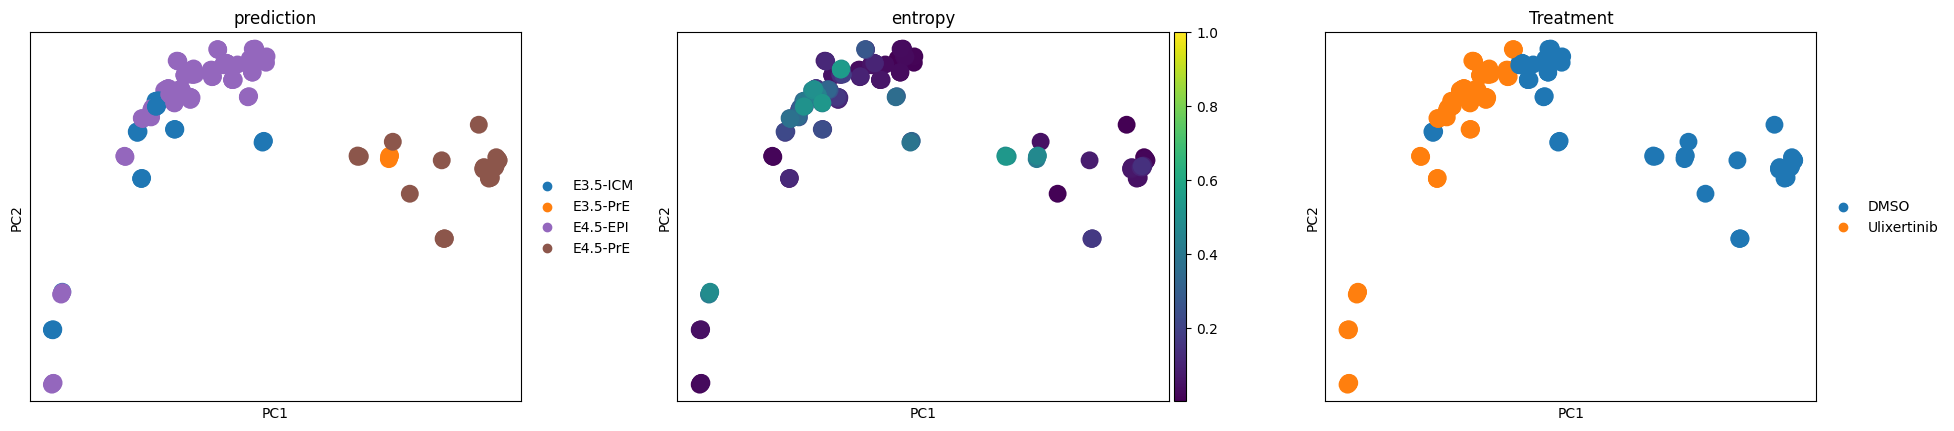

In [70]:
ax = sc.pl.pca(adata_sub, color = ['prediction', 'entropy', 'Treatment'], wspace=0.2, vmax=1, return_fig=True)
ax.savefig('../figures/07_pca.pdf')

### 4.2. Integration with mouse

In [71]:
import anndata
from scvi.model.utils import mde

In [ ]:
combined = anndata.concat([lvae.adata, lvae_q.adata])
combined.obs['dataset'] = 'Reference v1.1'
combined.obs.loc[lvae_q.adata.obs_names, 'dataset'] = 'Simon et al., 2024'

combined.obsm['X_scANVI'] = np.concatenate([lvae.get_latent_representation(), lvae_q.get_latent_representation()])

combined

AnnData object with n_obs × n_vars = 2189 × 3000
    obs: 'batch', 'experiment', 'technology', 'stage', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'ct_custom', 'prediction', 'dataset'
    obsm: 'X_scANVI'
    layers: 'counts'

In [ ]:
sc.pp.neighbors(combined, use_rep='X_scANVI')
sc.tl.draw_graph(combined)
sc.tl.umap(combined)

combined.obsm['X_mde'] = mde(combined.obsm['X_scANVI'], init="random")

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...


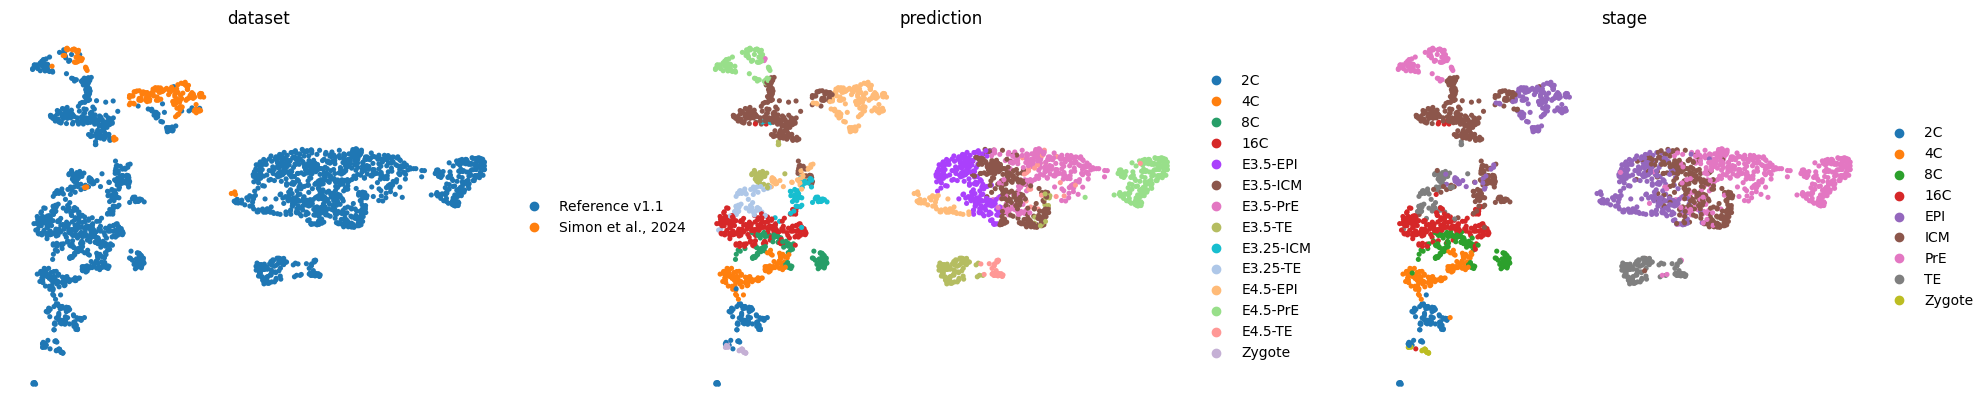

In [181]:
ax = sc.pl.umap(combined, color=['dataset', 'prediction', 'stage'], frameon=False, wspace=0.25, return_fig=True)
ax.savefig('../figures/07_umap.pdf')

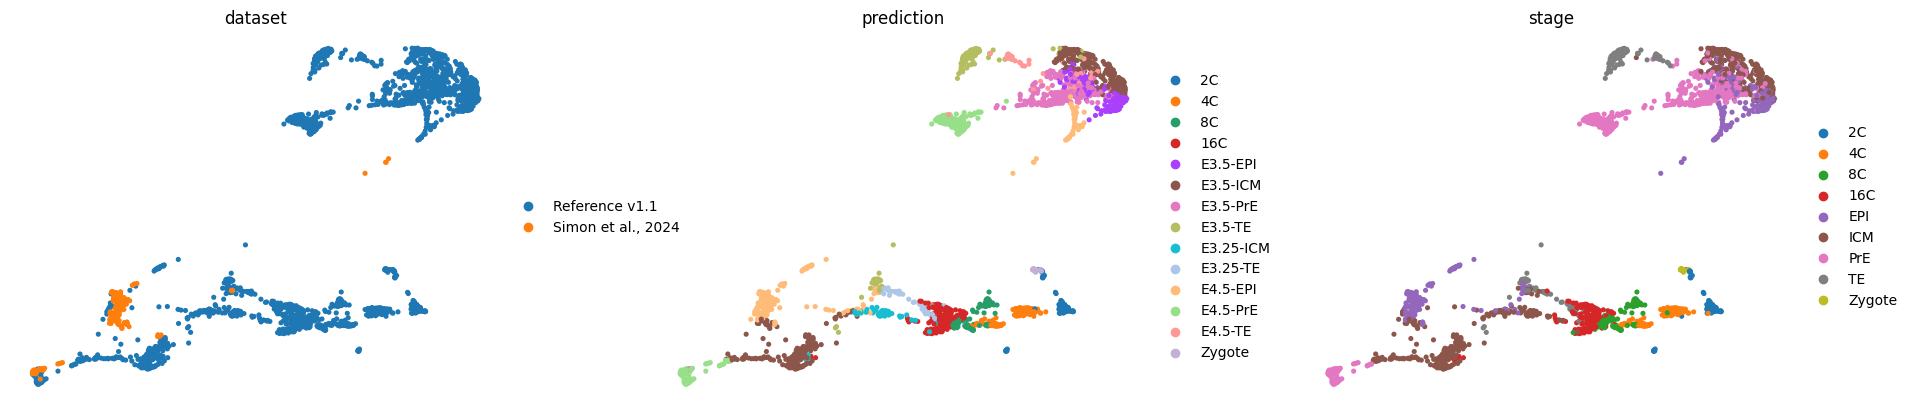

In [182]:
ax = sc.pl.draw_graph(combined, color=['dataset', 'prediction', 'stage'], frameon=False, wspace=0.2, return_fig=True)
ax.savefig('../figures/07_directed_graph.pdf')

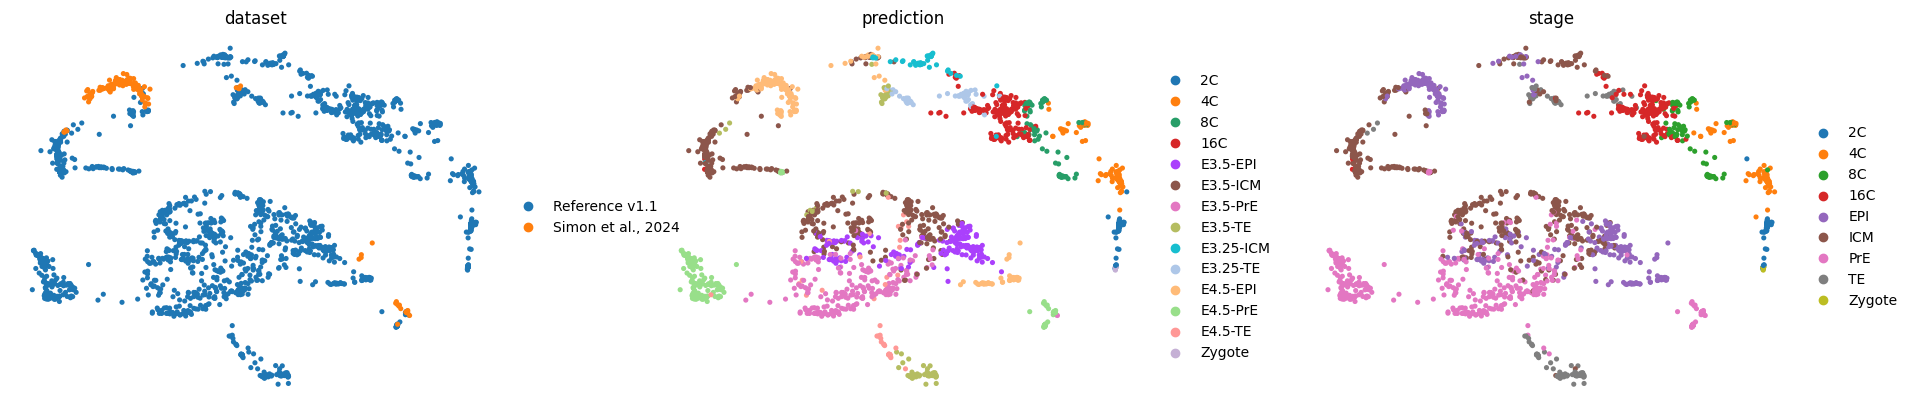

In [183]:
ax = sc.pl.embedding(combined, basis='X_mde', color=['dataset', 'prediction', 'stage'], frameon=False, wspace=0.2, return_fig=True)
ax.savefig('../figures/07_mde.pdf')

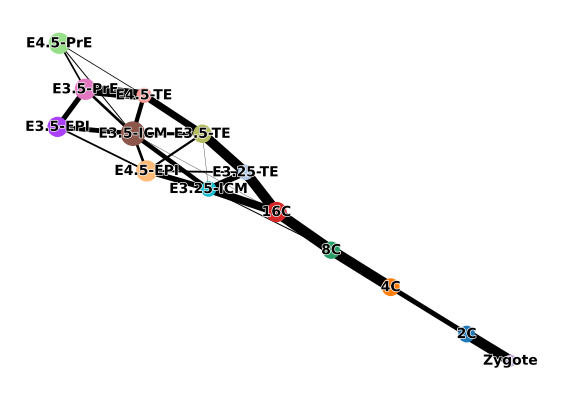

In [184]:
sc.tl.diffmap(combined)
sc.tl.paga(combined, groups='prediction')
sc.pl.paga(combined, color=['prediction'], frameon=False, fontoutline=True)
sc.tl.draw_graph(combined, init_pos='paga', n_jobs=10)

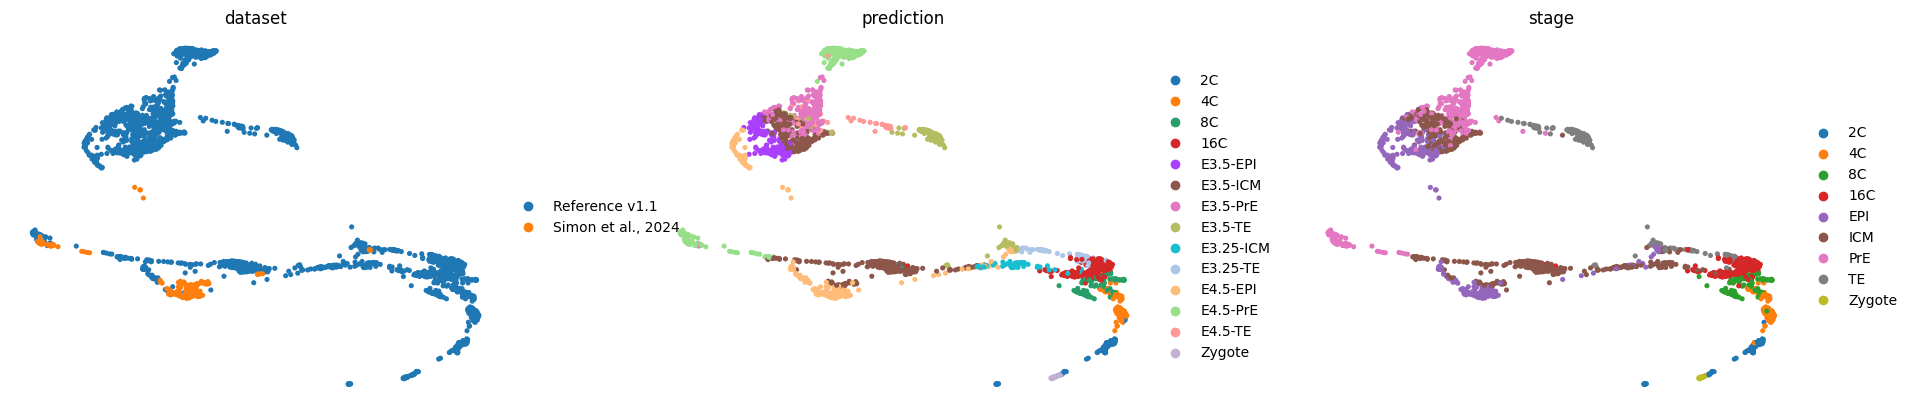

In [185]:
ax = sc.pl.draw_graph(combined, color=['dataset', 'prediction', 'stage'], frameon=False, wspace=0.2, return_fig=True)
ax.savefig('../figures/07_directed_graph_with_paga.pdf')

### 4.3. CAT analysis

In [140]:
lvae.adata.raw.to_adata().write('../data/processed/07_mouse_ref_1.1.h5ad')

In [163]:
tmp_adata = adata.raw.to_adata()
sc.pp.filter_genes(tmp_adata, min_cells=3)
tmp_adata[tmp_adata.obs.Treatment == "Ulixertinib"].write('../data/processed/07_simon_et_al.h5ad')

```bash
sbatch 07_CAT.sbatch
```

From CAT analysis, we can conclude that the predicted E4.5 EPI Ulix cells are **E3.5-ICM** and **E3.75-ICM** like cells. For more info, see the file `../results/07_CAT/Simon_REF_euclidean.html`

### 4.5. Counts

In [186]:
df = sc.metrics.confusion_matrix('Treatment', 'prediction', adata_sub.obs, normalize=False)
df.to_csv('../results/07_treatment_prediction_counts.csv')

display(df)

prediction,E3.5-ICM,E3.5-PrE,E4.5-EPI,E4.5-PrE
Treatment,,,,
DMSO,8,4,32,29
Ulixertinib,21,0,87,0


## 5. Differentially expressed genes

In [189]:
combined.obs['treatment'] = 'ATLAS_WT'
combined.obs.loc[lvae_q.adata.obs_names, 'treatment'] = lvae_q.adata.obs.Treatment

### 5.1. All EPI, ICM & PrE cells treated vs untreated

In [190]:
epi_icm_pre_cells = combined.obs.query('batch == "NIAKAN_1" & prediction.str.contains("ICM|EPI|PrE")').index.tolist()
subset = combined[epi_icm_pre_cells].copy()

sc.tl.rank_genes_groups(subset, groupby='treatment')
sc.get.rank_genes_groups_df(subset, group='Ulixertinib').to_csv('../results/07_Ulixertinib_vs_DMSO_EPI_ICM_PrE.csv')

#### 5.2. Only EPI & ICM cells treated vs untreated

In [193]:
epi_icm_cells = combined.obs.query('batch == "NIAKAN_1" & prediction.str.contains("ICM|EPI")').index.tolist()
subset = combined[epi_icm_cells].copy()

sc.tl.rank_genes_groups(subset, groupby='treatment')
sc.get.rank_genes_groups_df(subset, group='Ulixertinib').to_csv('../results/07_Ulixertinib_vs_DMSO_EPI_ICM.csv')

#### 5.3. EPI & ICM cells treated vs published (called as E3.5 ICM. E3.5 EPI, E4.5 EPI)

In [195]:
epi_icm_cells = combined.obs.query('batch == "NIAKAN_1" & treatment == "Ulixertinib" & prediction.str.contains("ICM|EPI")').index.tolist()
atlas_epi_icm = combined.obs.query('batch != "NIAKAN_1" & prediction.isin(["E3.5-ICM", "E3.5-EPI", "E4.5-EPI"])').index.tolist()

subset = combined[epi_icm_cells + atlas_epi_icm].copy()
sc.tl.rank_genes_groups(subset, groupby='treatment')
sc.get.rank_genes_groups_df(subset, group='Ulixertinib').to_csv('../results/07_Ulixertinib_vs_Atlas_EPI_ICM.csv')

#### 5.4. EPI & ICM cells untreated vs published (called as E3.5 ICM. E3.5 EPI, E4.5 EPI)

In [197]:
epi_icm_cells = combined.obs.query('batch == "NIAKAN_1" & treatment == "DMSO" & prediction.str.contains("ICM|EPI")').index.tolist()
atlas_epi_icm = combined.obs.query('batch != "NIAKAN_1" & prediction.isin(["E3.5-ICM", "E3.5-EPI", "E4.5-EPI"])').index.tolist()

subset = combined[epi_icm_cells + atlas_epi_icm].copy()
sc.tl.rank_genes_groups(subset, groupby='treatment')
sc.get.rank_genes_groups_df(subset, group='DMSO').to_csv('../results/07_DMSO_vs_Atlas_EPI_ICM.csv')